# Factor Analysis For Companies Based On Financial Metrics

## 前言
最近对因子分析（Factor Analysis）比较咁兴趣，其实最早接触因子分析（Factor Analysis）的知识点是在考CFA三级的时候，但没有过多深入。 最近因为一直在研究BackTrader这个开源量化平台，于是乎就着手回顾一下相应的理论知识模型。 关于因子分析的文章都好看了很多，但是发现基本没有人将其应用于股票市场当中，秉着“前人种树后人乘凉”的理念，终于在Medium上发现有大佬写了基于美股SP500的因子分析教程。出于学习的目的，这里就边学习边分析一下。
- 源码地址：https://quanp.readthedocs.io/en/latest/tutorials.html
- 原文地址：[Factor Analysis in Python - Characterising Companies Based on Financial Metrics During Covid19
](https://medium.com/swlh/factor-analysis-characterising-companies-based-on-financial-metrics-3d5fcc4e8b6f)
- 数据源：大佬已经将S&P500所有股票的基本面数据打包整合到Quanp这个python库中，`pip install quanp`直接安装即可

这里将跳过主因子分析（PCA）部分直接进入因子分析（Factor Analysis）。

In [42]:
import sys
# !conda install seaborn scikit-learn statsmodels numba pytables
# !conda install -c conda-forge python-igraph leidenalg
# !{sys.executable} -m pip install quanp
# !{sys.executable} -m pip install factor_analyzer 

### 引入库

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quanp as qp

from IPython.display import display
from matplotlib import rcParams
%matplotlib inline

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### 下载数据

In [44]:
# S&P 500 股票基本信息
#https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
df_metadata = qp.datasets.get_wiki_sp500_metadata()

# S&P 500 基本面数据（fundamentals）
df_fundamental = qp.datasets.download_tickers_fundamental()

The metadata file has been initialized and saved as D:\OneDrive - The City University of New York\Carnets\cnvar.cn\Factor Analysis\data\metadata/sp500_metadata.csv
Total tickers to download: 504


  df_fundamental[ticker] = df_tmp_fundamental[ticker]


Fundamentals appended sp500_metadata file has been save as D:\OneDrive - The City University of New York\Carnets\cnvar.cn\Factor Analysis\data\metadata/sp500_metadata_fundamentalAdded.csv


说明：数据会自动下载到**data/metadata/** 这个文件夹中，下面直接加载即可

### 加载数据

In [45]:
# 加载下载的csv数据
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)

#剔除含零的列
df_fundamental = df_fundamental.loc[:, (df_fundamental != 0).any(axis=0)]

df_fundamental.columns

Index(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'beta',
       'bookValuePerShare', 'currentRatio', 'dividendAmount', 'dividendDate',
       'dividendPayAmount', 'dividendPayDate', 'dividendYield',
       'epsChangePercentTTM', 'epsChangeYear', 'epsTTM', 'grossMarginMRQ',
       'grossMarginTTM', 'high52', 'interestCoverage', 'low52',
       'ltDebtToEquity', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ',
       'netProfitMarginTTM', 'operatingMarginMRQ', 'operatingMarginTTM',
       'pbRatio', 'pcfRatio', 'peRatio', 'pegRatio', 'prRatio', 'quickRatio',
       'returnOnAssets', 'returnOnEquity', 'returnOnInvestment', 'revChangeIn',
       'revChangeTTM', 'sharesOutstanding', 'symbol', 'totalDebtToCapital',
       'totalDebtToEquity', 'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
      dtype='object')

In [46]:
ls_fundamental_target = ['beta','bookValuePerShare','currentRatio', 'dividendYield',
                         'epsChangePercentTTM','epsChangeYear', 'epsTTM', 'grossMarginMRQ', 
                         'grossMarginTTM', 'interestCoverage', 'ltDebtToEquity', 
                         'marketCap', 'marketCapFloat', 'netProfitMarginMRQ', 
                         'netProfitMarginTTM', 'operatingMarginMRQ', 'operatingMarginTTM', 
                         'pbRatio', 'pcfRatio','peRatio', 'pegRatio', 'prRatio', 
                         'quickRatio', 'returnOnAssets','returnOnEquity', 'returnOnInvestment', 
                         'revChangeIn', 'revChangeTTM', 'sharesOutstanding', 
                         'totalDebtToCapital', 'totalDebtToEquity', 'vol10DayAvg', 
                         'vol1DayAvg', 'vol3MonthAvg']

df_fundamental_target = df_fundamental[ls_fundamental_target]

In [47]:
df_fundamental_target.head()

,beta,bookValuePerShare,currentRatio,dividendYield,epsChangePercentTTM,epsChangeYear,epsTTM,grossMarginMRQ,grossMarginTTM,interestCoverage,ltDebtToEquity,marketCap,marketCapFloat,netProfitMarginMRQ,netProfitMarginTTM,operatingMarginMRQ,operatingMarginTTM,pbRatio,pcfRatio,peRatio,pegRatio,prRatio,quickRatio,returnOnAssets,returnOnEquity,returnOnInvestment,revChangeIn,revChangeTTM,sharesOutstanding,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg
MMM,0.90883,8.80101,1.57911,4.05,0.00000,0.00000,9.60319,45.33922,46.00515,15.80000,99.13597,83674.410,568.60530,14.73553,15.83222,18.58648,19.85679,5.60445,11.14470,15.31158,0.000000,2.36817,1.00109,12.02558,39.01011,14.84253,2.51974,7.19964,5.690588e+08,52.64188,111.70800,2695393.0,2695390.0,67823610.0
AOS,1.13934,5.87302,1.71779,1.88,32.22964,26.08051,3.17847,34.93914,36.39396,105.40000,15.95445,9302.692,129.10130,12.25325,13.58736,16.01718,17.50720,5.19698,15.82360,18.76060,0.582092,2.48231,1.23012,15.56782,27.84111,21.65196,0.00000,23.78939,1.300359e+08,14.03792,16.33037,864387.0,864390.0,23492210.0
ABT,0.71987,7.79507,1.85253,1.64,34.92305,37.77927,4.33188,58.07482,57.14382,25.54386,48.26690,201130.700,1738.05700,20.57167,17.35409,24.48087,20.73056,5.68182,18.03540,26.51736,0.759308,4.51837,1.40255,10.52510,22.40397,12.74469,3.72340,19.21903,1.750942e+09,32.41716,48.27820,5811787.0,5811790.0,116640030.0
ABBV,0.80438,24.51570,0.81513,3.75,145.95560,26.21560,6.97193,70.29842,69.77876,8.91667,390.11240,266073.800,1764.87800,33.18806,22.01322,34.84267,32.68048,16.33839,12.73568,21.59660,0.147967,4.69059,0.70803,8.50289,82.67262,10.89683,0.00000,13.00926,1.767110e+09,81.83053,451.23140,6319170.0,6319170.0,157797210.0
ABMD,1.36084,26.10269,7.05254,0.00,0.00000,5.56105,2.96416,80.93126,81.76327,0.00000,0.00000,11890.820,44.60342,22.35501,13.23040,24.08857,13.63892,7.90639,72.24334,88.04181,0.000000,11.52487,6.37376,8.61841,9.63678,9.41308,3.32113,21.73761,4.556394e+07,0.00000,0.00000,390682.0,390680.0,6340010.0


## 充分性测试(Adequacy Test)

在做因子分析之前, 我们需要先做充分性检测, 判断数据集中是否存在因子（factor）：
- `Bartlett's Test`: 是用来检测已知（可观察）变量的相关矩阵是否单位矩阵，如果不是，那么变量之间存在相关性, 可采用因子分析
- `Kaiser-Meyer-Olkin(KMO) Test`: 检测数据对因子分析的适用性。KMO 值的范围介于 0 和 1 之间。 KMO数值越大，变量间的相关性越强。KMO 值需要大于 0.6 才视为适用

````{margin}
```{note}
仅当每个变量的样本少于 5 个时，才建议进行Bartlett's Test。在我们的例子中，我们有 23 个变量，总共 505 个样本（公司）。因此，我们不需要做此测试。但是，我们将执行此操作以查看它是否重要。 P 值为 0（显着），尽管它不是可靠的“优选结论”。
```
````

In [48]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
print('Bartlett-sphericity Chi-square: {}'.format(calculate_bartlett_sphericity(df_fundamental_target)[0]))
print('Bartlett-sphericity P-value: {}'.format(calculate_bartlett_sphericity(df_fundamental_target)[1]))

Bartlett-sphericity Chi-square: 18834.170518792038
Bartlett-sphericity P-value: 0.0


**说明：** p_value=0, 表明数据变量间的相关矩阵不是单位矩阵，具有显著的关联性，可采用因子分析. p_value需要少于0.5

In [49]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_fundamental_target[df_fundamental_target.columns]);
print('KMO score: {}'.format(kmo_model));

KMO score: 0.6726149090611923


**说明：** KMO 值大于 0.6 ，符合因子分析的适用性

### 估算因子数和剔除少于0.2公因子方差的变量（Estimating number of factors and filtering for variables with communalities > 0.2）
> Here, as we are only interested to know how many significant factors we should use for the following work, we used a simple factor analysis without any rotation. In fact, we can just use the estimation based on the PCA variance ratio (eigenvalue) above.

在这里，由于我们只想知道我们应该在接下来的工作中使用多少重要因子，因此我们只进行简单的因子分析，不使用任何矩阵旋转方式（之前的example中使用了varimax作为rotation）。 实际上，我们可以只使用上面基于 PCA 方差比（特征值）的估计（这里删掉了PCA部分）。

In [50]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation=None)
fa.fit(df_fundamental_anndata)
ev, v = fa.get_eigenvalues()

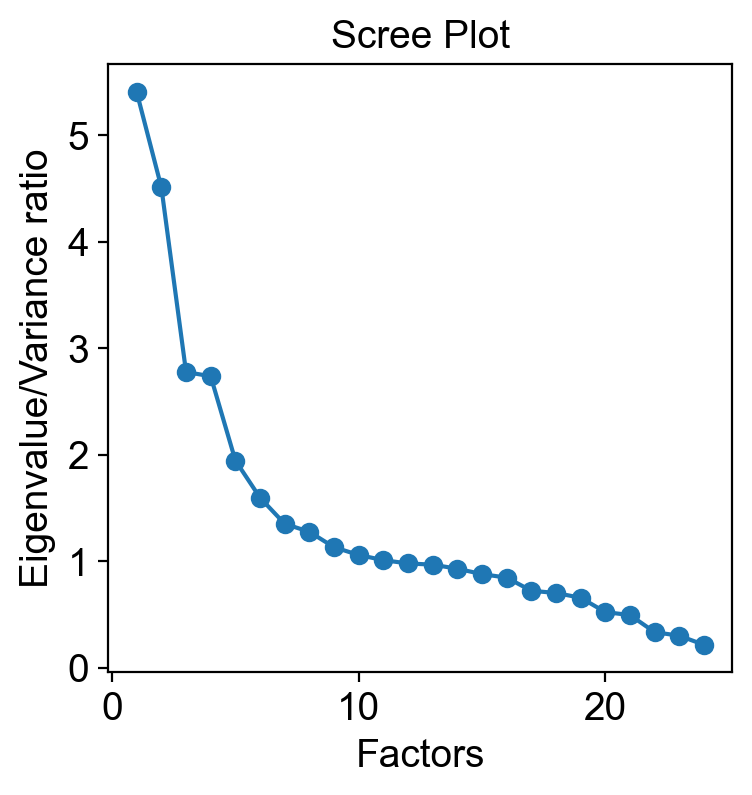

In [51]:
# create scree plot using matplotlib
plt.scatter(range(1, 25), ev[:24])
plt.plot(range(1,25), ev[:24])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue/Variance ratio')
plt.grid()
plt.show()

>Again, we see that the elbow point on the screen plot fall at about F5. Next, the communalities of the variables/features are inspected to see if the variables are well defined by the solution. Communalities indicate the percent of variance in a variable that overlaps variance in the factors. Ideally, we should drop variables with low communalities, for example, exclude those variables with <0.2 communalities. Here, found only 22 of 34 variables had commualities >0.2. However, for the exploratory purpose of this dataset, we don't consider removing those variables.

我们看到图上的曲线肘点（elbow point）落在 F5 左右。 接下来，检查变量（特征）的公因子方差（communalities)以查看变量是否很好地被解释。公因子方差表示变量中与因子方差重叠的方差百分比。 理想情况下，我们应该删除具有低公因子方差的变量，例如，排除那些具有 <0.2 的公因子方差的变量。 在这里，发现 34 个变量中只有 22 个的公因子方差 > 0.2。 但是，出于对这个数据集的探索性目的，我们不考虑删除这些变量。

In [52]:
communalities = pd.DataFrame(fa.get_communalities(), index=list(df_fundamental_anndata.columns))
features_comm = list(communalities[communalities[0] > 0.2].index)
print('Total variables/features with communalities >0.2: {}'.format(len(features_comm)))
    

Total variables/features with communalities >0.2: 18


### Factor analysis with Varimax (orthogonal) rotation and Maximum Likelihood factor extraction method

In [53]:
fa = FactorAnalyzer(rotation='varimax', n_factors=5, method='ml')
fa.fit(df_fundamental_anndata);

# # check eigenvalues
# ev, v = fa.get_eigenvalues()

In [54]:
fa_loading_matrix = pd.DataFrame(fa.loadings_, columns=['FA{}'.format(i) for i in range(1, 5+1)], 
                              index=df_fundamental_anndata.columns)
fa_loading_matrix['Highest_loading'] = fa_loading_matrix.idxmax(axis=1)
fa_loading_matrix = fa_loading_matrix.sort_values('Highest_loading')
fa_loading_matrix

,FA1,FA2,FA3,FA4,FA5,Highest_loading
vol3MonthAvg,0.941290,-0.000984,-0.010029,0.018500,0.275434,FA1
vol10DayAvg,0.946649,-0.005869,-0.014880,0.022796,0.316813,FA1
sharesOutstanding,0.903524,0.078796,-0.016071,-0.126117,-0.395341,FA1
dividendYield,0.085416,0.048170,0.028086,-0.227944,-0.145986,FA1
returnOnEquity,0.012507,-0.011500,-0.010655,-0.005573,-0.029119,FA1
...,...,...,...,...,...,...
currentRatio,0.012777,0.030565,-0.042528,0.300665,0.082227,FA4
epsChangeYear,-0.010450,-0.030207,-0.012540,0.002032,0.023429,FA5
revChangeIn,-0.021071,0.070437,-0.042578,-0.004015,0.096852,FA5
revChangeTTM,0.055924,-0.070893,0.094255,-0.020104,0.162444,FA5


> We can revisit the correlation matrix plot of the features/variables of this dataset - shown below. The underlying variables in respective factors are usually highly correlated but least correlated with the underlying variables in other factors.

我们可以重新访问该数据集的特征/变量的相关矩阵图 - 如下所示。 各个因子中的基础变量通常与其他因子中的基础变量高度相关，但相关性最低。

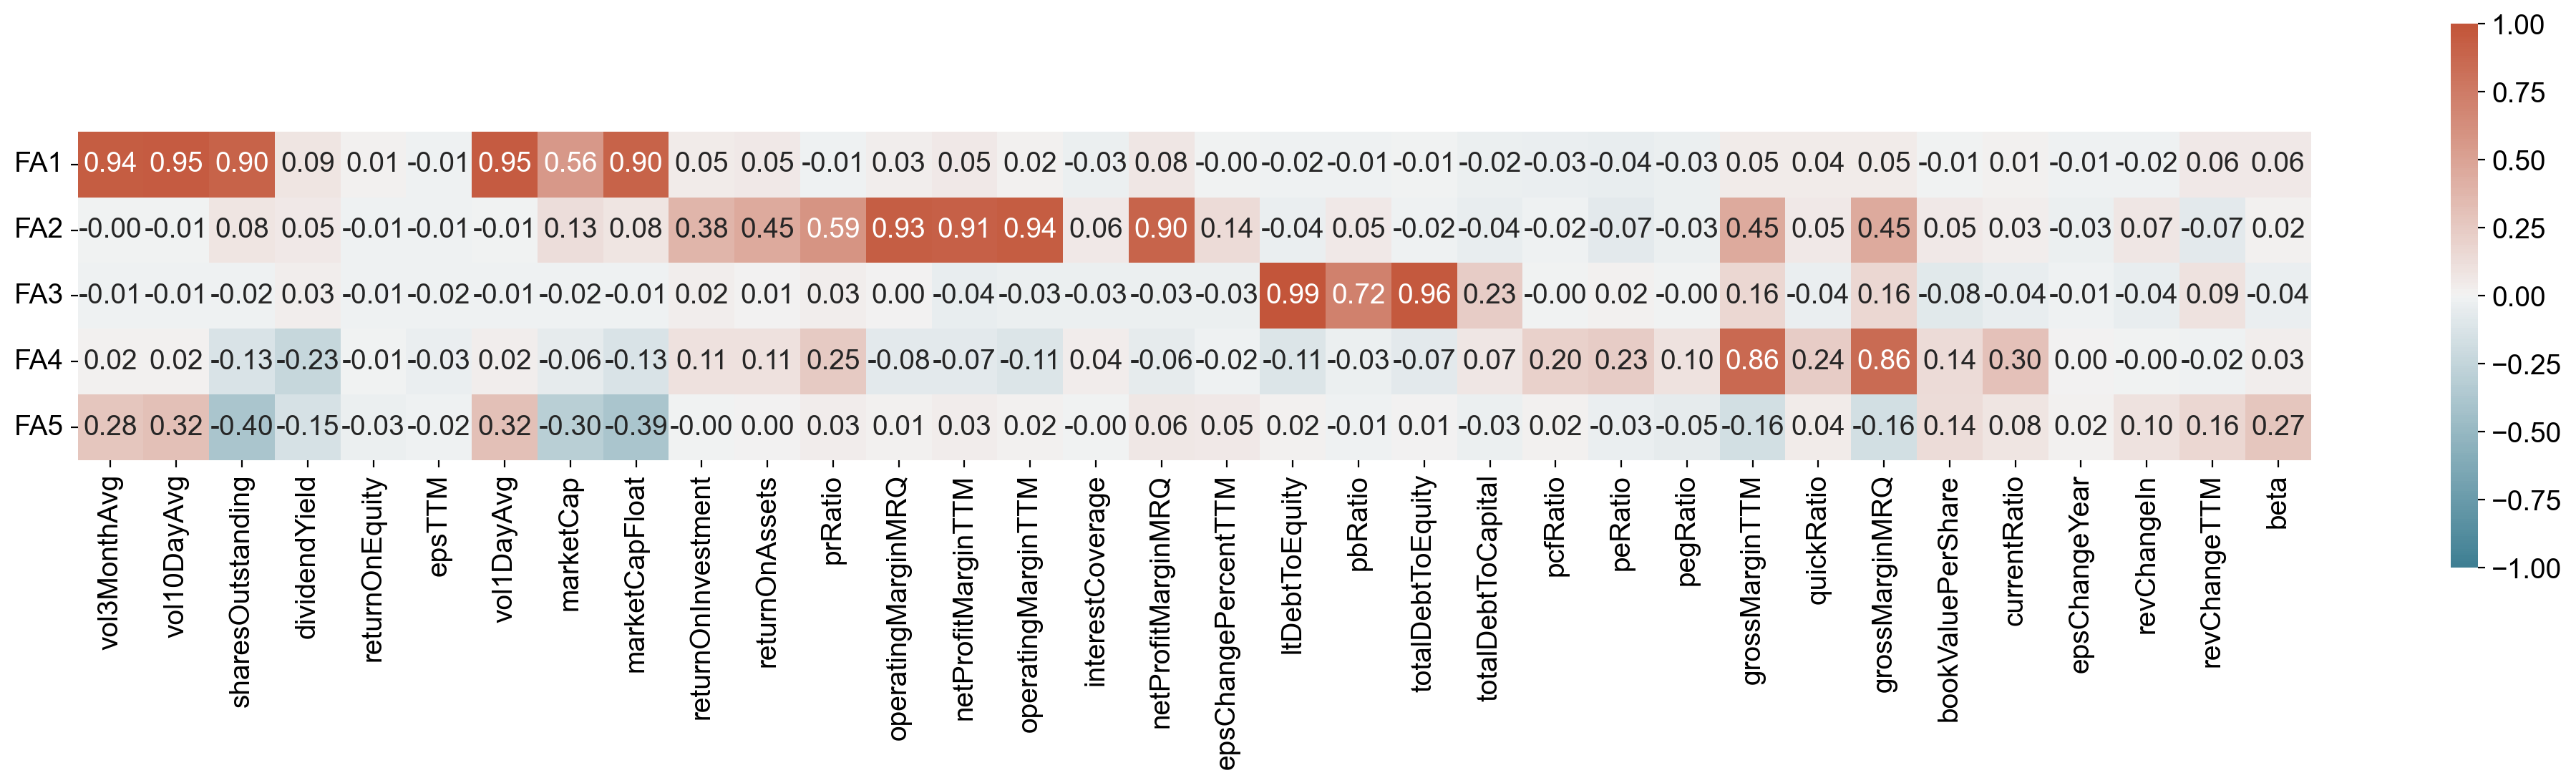

In [55]:
import seaborn as sns

plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(fa_loading_matrix.drop('Highest_loading', axis=1).T, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(220, 20, n=200),
                square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

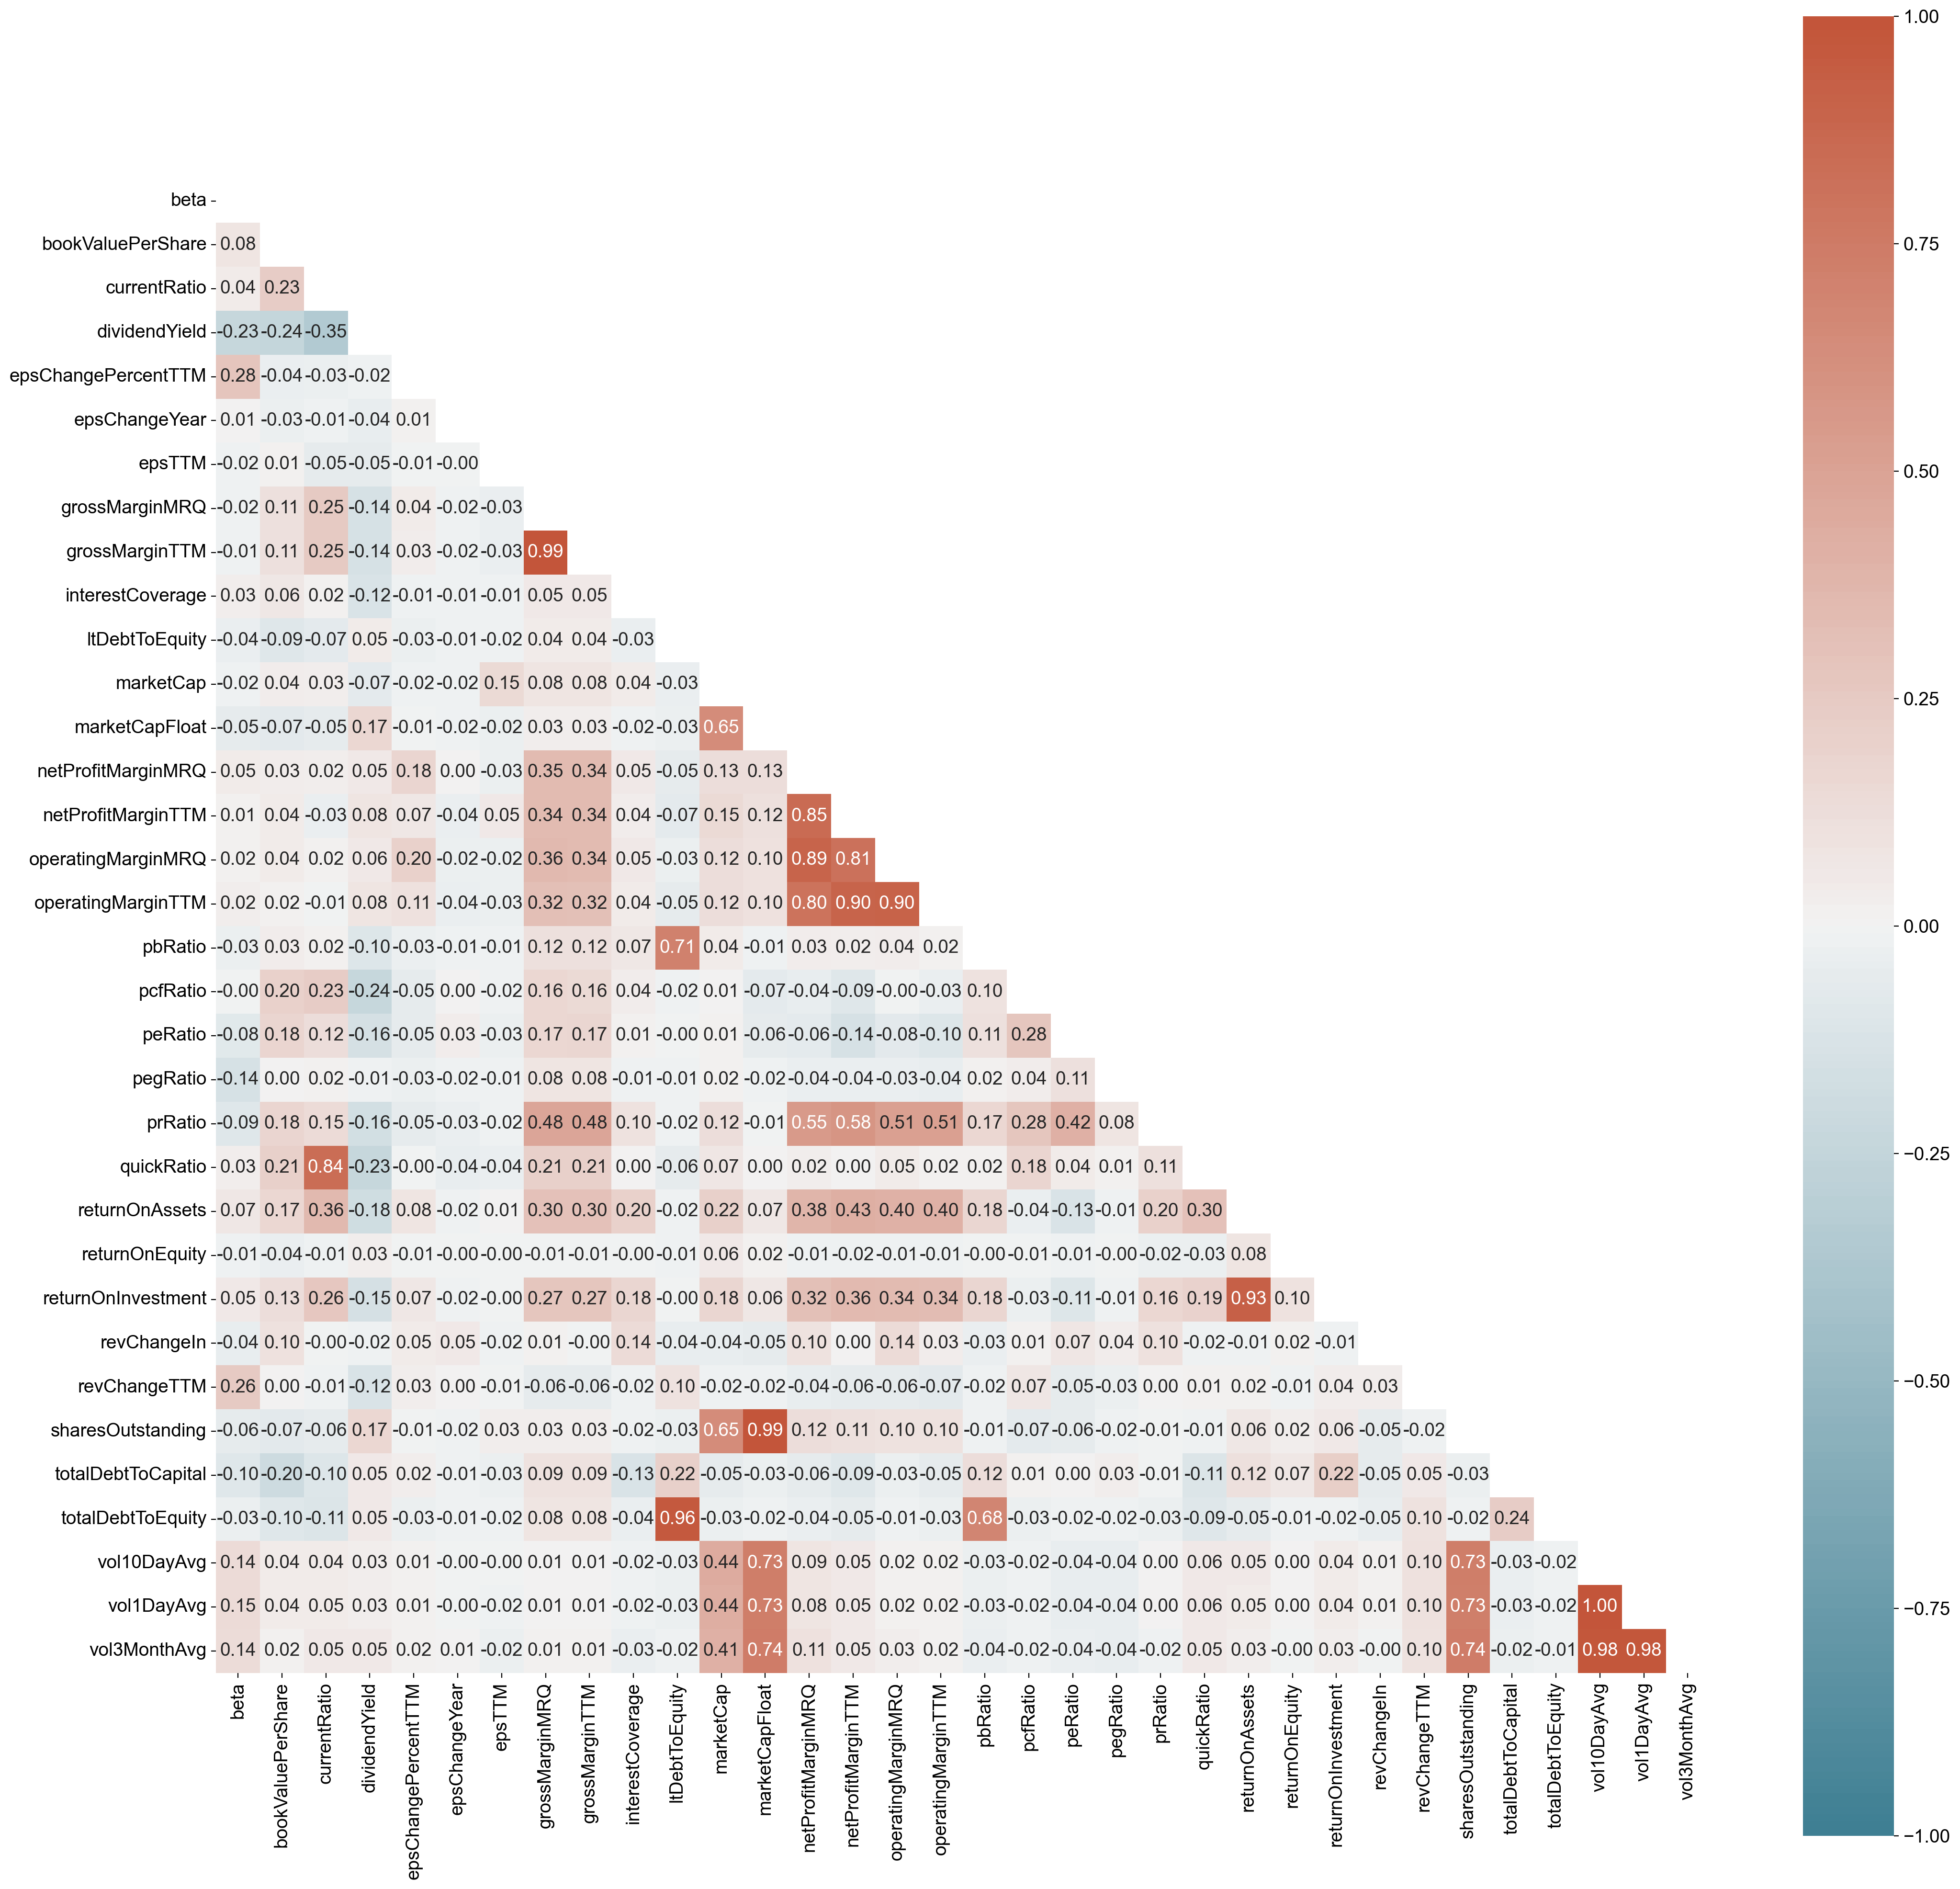

In [56]:
import seaborn as sns

plt.figure(figsize=(25,25))

# plot the heatmap for correlation matrix
corr = df_fundamental_anndata.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 mask=mask, square=True, 
                 annot=True, fmt='.2f')

---

>As a rule of thumb, only variables with loading of 0.32 and above are interpreted. The greater the loading, the more the variable is a pure measure of the factor. Comrey and Lee (1992) suggest that loadings of:-  
\>71% (50% overlapping variance) are considered excellent;  
\>63% (40% overlapping variance) very good;  
\>55% (30% overlapping variance) good;  
\>45% (20% overlapping variance) fair;  
<32% (10% overlapping variance) poor;


根据经验，只有负载为 0.32 及以上的变量才会被解释。 成分矩阵(loading)值越大，变量越可能作为因子去度量。 Comrey and Lee (1992) 建议加载：-

- \>71%（50%的重叠方差）被认为是优秀的；
- \>63%（40% 重叠方差）非常好；
- \>55%（30% 重叠方差）好；
- \>45%（20% 重叠方差）一般；
- \<32%（10% 重叠方差）差；

---

> In summary, based on the heatmap above: 
>- the Factor 1 (FA1) seems to suggest operational/return performance or valuations of a company; 
>- FA2 is more correlated to volalities of company share values/market capitals; 
>- FA3 seems to suggest long term debt obligations; 
>- FA4 seems to suggest short-term debt obligation (i.e. quick/current ratio); and lastly 
>- FA5 seems to be correlated with gross margin performance of a company.

**综上所述，根据上面的热图：**
- 因子1 (FA1) 似乎暗示了公司的运营/回报业绩或估值；
- FA2 与公司股票价值/市值的波动性更相关；
- FA3 似乎暗示长期债务义务；
- FA4 似乎暗示短期债务义务（即速动/流动比率）； 
- FA5 似乎与公司的毛利率表现相关。

---


## Final words
Factor analysis (FA) dimensional reduction seems to be a better approach than PCA (which is a more empirical summary approach compared to FA) if we are interested in a theoretical solution uncontaminated by unique and error variability and have designed our study on the basis of underlying constructs that are expected to produce scores on the observed variables. In this FA study, we were using Varimax rotation (an orthogonal rotation so that all the factors are uncorrelated with each other) - this could in turn be more useful latent variables for factor model in both multiple linear or logistic-based regressions, eg. to predict positive or negative return of a stock price performance. 

## References
1. Loadings vs eigenvectors in PCA: when to use one or another? https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another
2. Making sense of principal component analysis, eigenvectors & eigenvalues
 https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/35653#35653
3. Tabachnick & Fidell. Using Multivariate Statistics, Sixth Edition. PEARSON 2013; ISBN-13:9780205956227.